In [1]:
import pandas as pd

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

In [2]:
dbname = 'cluj'
engine = create_engine('postgres://%s:%s@localhost/%s'%('docker','docker',dbname))

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [17]:
sql = """
    SELECT * FROM matchup_results WHERE matchup_period = 16
"""

In [18]:
matchup_results = pd.read_sql(sql, engine)
matchup_results.shape

(12, 19)

In [29]:
#matchup_results.head()

In [40]:
sql = """
    SELECT * FROM predictions WHERE matchupperiod = 16
"""

In [41]:
predictions = pd.read_sql(sql, engine)
predictions.shape

(84, 12)

In [42]:
#predictions.head()

In [124]:
final = pd.DataFrame()
for teamdId in range(1,13):
    
    mr_select = matchup_results.loc[matchup_results.team == teamdId]
    pr_select = predictions.loc[predictions.team == teamdId]
    
    ast_result = (mr_select.asts.values[0] > mr_select.opp_asts.values[0]) * 1
    reb_result = (mr_select.rebs.values[0] > mr_select.opp_rebs.values[0]) * 1
    pts_result = (mr_select.pts.values[0] > mr_select.opp_pts.values[0]) * 1
    stls_result = (mr_select.stls.values[0] > mr_select.opp_stls.values[0]) * 1
    blks_result = (mr_select.blks.values[0] > mr_select.opp_blks.values[0]) * 1
    threes_result = (mr_select.threes.values[0] > mr_select.opp_threes.values[0]) * 1
    fg_result = (mr_select.fg_pct.values[0] > mr_select.opp_fg_pct.values[0]) * 1
    ft_result = (mr_select.ft_pct.values[0] > mr_select.opp_ft_pct.values[0]) * 1
    result_dict = {'assists':ast_result, 'blocks':blks_result, 'fg_pct':fg_result, 'ft_pct':ft_result,
                  'points':pts_result, 'rebounds':reb_result, 'steals':stls_result, 'threes':threes_result}
    result = pd.DataFrame(result_dict, index=[0])
    result = result.transpose().rename(columns={0:'result'})
    
    cats = ['assists','blocks','fg_pct','ft_pct','points','rebounds','steals','threes']
    index = ['days_to_end']
    pivoted = pr_select[cats+index].pivot_table(index=index, values=cats).transpose()
    
    merged = pd.concat([pivoted, result], axis=1)
    merged['teamId'] = teamdId
    final = pd.concat([final, merged])


In [127]:
final[[0,'result']].corr()

,0,result
0,1.000000,0.893171
result,0.893171,1.000000


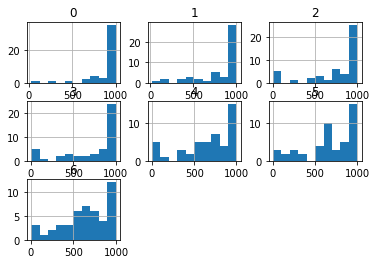

In [139]:
final.loc[final.result == 1][[0,1,2,3,4,5,6]].hist();

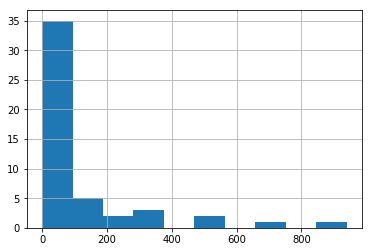

In [132]:
final.loc[final.result == 0][0].hist()